In [1]:
import firedrake as fd
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import ufl
import control

import hydrogym.firedrake as hgym
from lti_system import control_vec, real_form, LinearBDFSolver

output_dir = "../eig_output"
# output_dir = "../re40_med_eig_output"
output_dir = "./re100_med_eig_output"
# output_dir = "../re40_fine_eig_output"

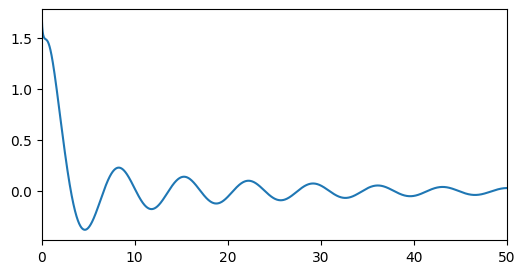

In [2]:
# Load data from model_reduction/step_response.py
step_response = np.load("re100_impulse_output/long_response.npy")
t, CL = step_response[:, 0], step_response[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(t, CL, label="CL")
ax.set_xlim([0, 50])
plt.show()


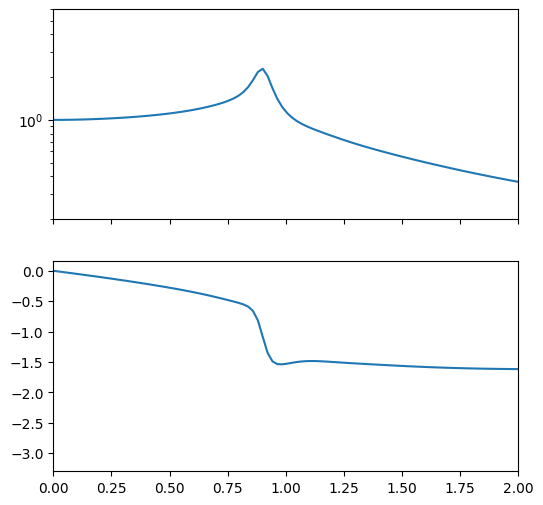

In [3]:
# Fourier transform of the step response
# Compare to transfer_function.ipynb

fs = 1 / (t[1] - t[0])

n = len(CL)
freqs = 2 * np.pi * np.fft.fftfreq(n, d=1/fs)
CL_fft = np.sqrt(1 / 2 * np.pi) * np.fft.fft(CL) / fs

CL_fft = CL_fft / CL_fft[0]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]))
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.angle(CL_fft[:n//2]))
ax[1].set_xlim(0, 2)
plt.show()


In [4]:
flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{output_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


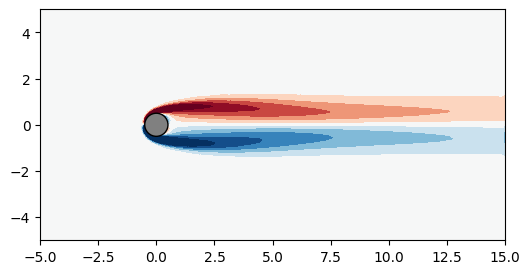

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


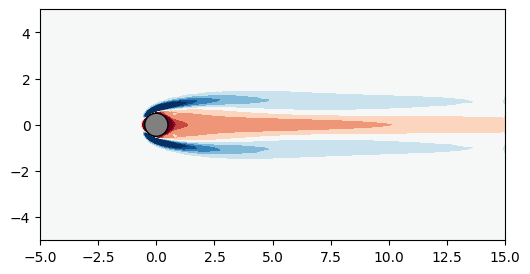

In [6]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure

qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

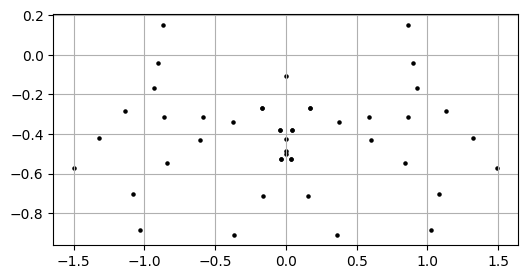

In [7]:
# 3. Global stability
# Plot eigenvalues

evals = np.load(f"{output_dir}/evals.npy")

plt.figure(figsize=(6, 3))
plt.scatter(evals.imag, evals.real, s=5, c='k')
plt.grid()
plt.show()

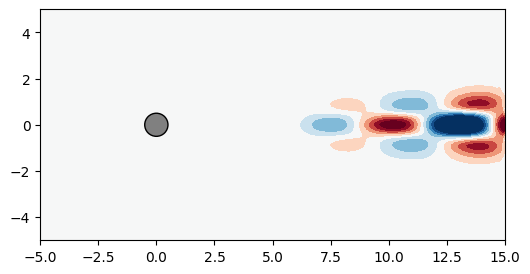

In [8]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-0.5, 0.5))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

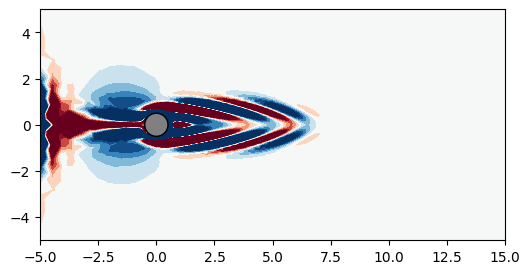

In [9]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-50, 50))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

In [10]:
# Load the set of eigenvectors
r = len(evals)
tol = 1e-10
V = []
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V.append(q)

W = []
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W.append(q)


# Sort by real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V = [V[i] for i in sort_idx]
W = [W[i] for i in sort_idx]

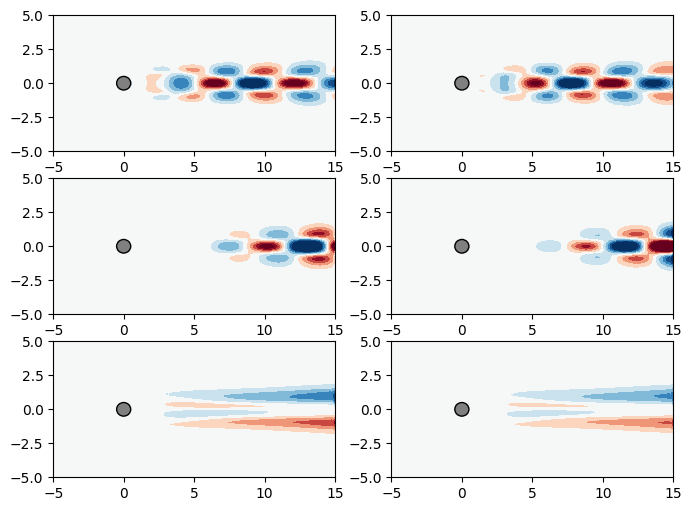

In [11]:
# Plot direct modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

clim = (-0.5, 0.5)
for i in range(0, n_plt):

    # Real part
    flow.q.assign(V[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * V[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

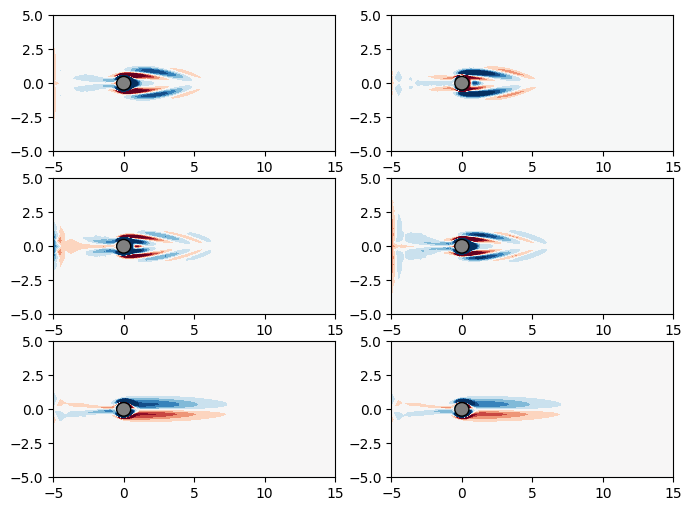

In [12]:
# Plot adjoint modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

for i in range(0, n_plt):

    alpha = flow.inner_product(W[2 * i], W[2 * i])
    clim = np.array([-1, 1]) * np.sqrt(abs(alpha))

    # Real part
    flow.q.assign(W[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * W[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

### Natural flow (no actuation)

In [13]:
data_no_act = np.load("re100_open_loop_output/no_actuation.npz")
t = data_no_act['t']
u = data_no_act['u'][:, None]
xc = data_no_act['x']
y = data_no_act['y'][:, None]

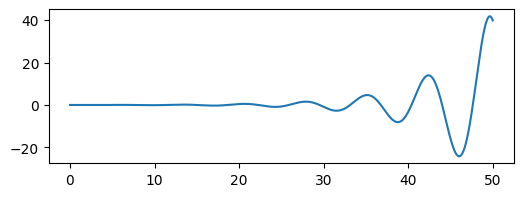

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
ax.plot(t, y)
plt.show()

### Projection onto global modes

In [96]:
# 4. Projection onto global modes

# r = 28  # Number of global modes for projection
r = len(evals)
print(f"{r=}")
Ar = np.zeros((r, r), dtype=np.complex128)
Br = np.zeros((r, 1), dtype=np.complex128)
Cr = np.zeros((1, r), dtype=np.complex128)

A = flow.linearize(qB)
A.copy_output = True

def meas(q):
    flow.q.assign(q)
    CL, _CD = flow.get_observations()
    return CL

def real_part(q):
    return

for i in range(r):
    for j in range(r):
        # Ar[j, i] = flow.inner_product(A @ V[i], W[j])

        # Specifically for this projection, we know the result is diagonal
        Ar[j, i] = 0.0
        if i == j:
            if np.isclose(evals[i].imag, 0.0, atol=tol):
                Ar[j, i] = evals[i].real
            else:
                Ar[j, i] = evals[i]

    # Br[i, 0] = flow.inner_product(qC, W[i])
    Br[i, 0] = flow.inner_product(W[i], qC)
    Cr[0, i] = meas(V[i])

# Finally the feedthrough term
Dr = meas(qC)

r=46


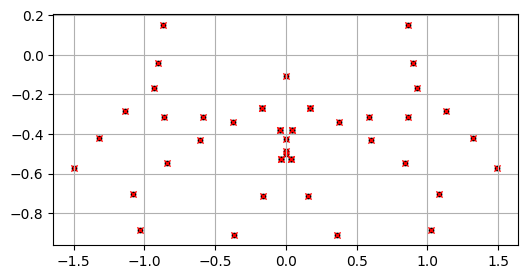

In [97]:
rom_evals = np.linalg.eigvals(Ar)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(rom_evals.imag, rom_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.grid()

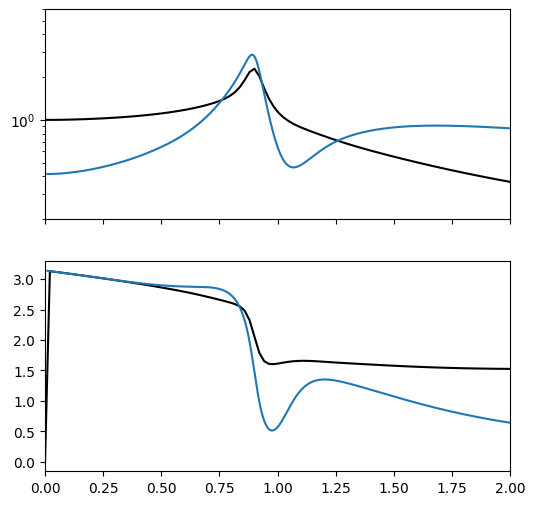

In [98]:
def H(s):
    return Cr @ np.linalg.inv(s * np.eye(r) - Ar) @ Br + Dr

omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax[0].semilogy(omega.imag, np.abs(H_omega))
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.mod(np.angle(CL_fft[:n//2]), np.pi), 'k')
ax[1].plot(omega.imag, np.angle(H_omega))


In [99]:
A_hat, B_hat, C_hat, D_hat, T = real_form(Ar.conj(), Br.conj(), Cr.conj(), Dr)
T_inv = linalg.inv(T)

In [100]:
# Need to be able to project and recover the right observation

q0 = fd.project(ufl.imag(V[1]), flow.mixed_space)
# q0 = fd.project(V[1], fn_space)
# q0 = fd.project(0.5 * (V[0] + V[1]), fn_space)
flow.q.assign(q0)
print(flow.get_observations()[0])
# q0.assign(q0 / flow.inner_product(q0, q0))

z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
# z0 = np.array([flow.inner_product(W[j], q0) for j in range(r)])
# print(z0[:2])

x0 = T_inv @ z0
# print(x0[:2])

print(C_hat @ x0)

(-0.010504028052849394+0j)
[-0.01050403-3.05739799e-13j]


In [101]:
q0 = fd.Function(flow.mixed_space).project(ufl.imag(V[0]))
# q0 = fd.Function(flow.mixed_space).assign(0.5 * (V[0] + V[1]))
# q0 = fd.Function(flow.mixed_space).assign(0.5j * (-V[0] + V[1]))
flow.q.assign(q0)
print(flow.get_observations()[0])
z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
# print(z0[:2])
x0 = T_inv @ z0
# print(x0[:2])
C_hat @ x0

(0.010504028052849394+0j)


array([0.01050403+3.05739799e-13j])

### Controller design in the small-gain limit

See 6.2 in Barbagallo et al.

In [102]:
complex_rom = False

In [103]:
ru = 2
m = 1
p = 1

if complex_rom:
    # Low-gain limit
    Q = np.zeros((ru, ru))
    R = np.eye(m)
    P = linalg.solve_continuous_are(A_hat[:ru, :ru], B_hat[:ru], Q, R)

    K = np.zeros_like(B_hat.T)
    Ku = linalg.solve(R, B_hat[:ru].T) @ P
    K[:, :ru] = Ku
    print(Ku)

else:
    # Approximate low-gain limit with large R matrix
    Q = np.eye(r)
    R = 1e8 * np.eye(m)
    K, _, E = control.lqr(A_hat, B_hat, Q, R)
    print(K[0, :2])
    # print(E)

# Integral control on the actuation to drive the BC value to zero
ki = 1e-1

[0.21791025 0.03085916]


(0.1, 10)

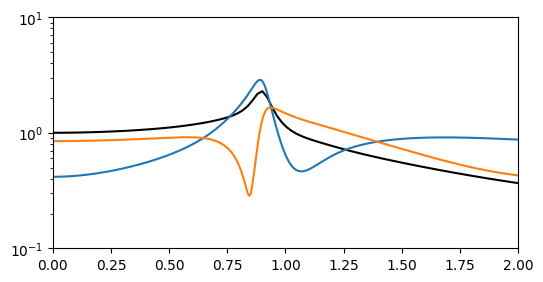

In [104]:
def H_cl(s):
    return C_hat @ np.linalg.inv(s * np.eye(r) - (A_hat - B_hat @ K)) @ B_hat + D_hat

# Plot the transfer function
omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])
H_cl_omega = np.array([H_cl(s).ravel() for s in omega])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
ax.semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax.semilogy(omega.imag, np.abs(H_omega))
ax.semilogy(omega.imag, np.abs(H_cl_omega))
ax.set_xlim(0, 2)
ax.set_ylim(0.1, 10)

### LQR control only

Full state measurement in the reduced basis by projecting the field at every time step. Intended for debugging only

In [105]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

tf = 50
n_steps = int(tf // dt)
CL_ctrl = np.zeros(n_steps)
CD_ctrl = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# # Integrated control signal (this is the BC value)
# c = np.zeros((n_steps, m))

rho = np.zeros(n_steps)
# rho = 0.0

flow.q.assign(solver.q)
for i in range(n_steps):
    # Project the flow field onto the reduced basis
    z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])
    # z = np.array([flow.inner_product(W[j], flow.q) for j in range(r)])

    if i > 0:
        # Transform to the real-valued reduced state space
        x[i] = np.real(T_inv @ z)

        # LQR control
        u[i] = -K @ x[i]

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        # u[i] += 1e-1 * rho[i-1]

        c.assign(u[i])
        rho[i] = rho[i-1] - dt * u[i]

    q = solver.step()
    flow.q.assign(q)
    CL_ctrl[i], CD_ctrl[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_ctrl[i]:.4f}, CD={CD_ctrl[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=0.0
t=0.01, CL=0.0089, CD=0.0000
   u=[-0.06032895], rho=0.0006032895401019715
t=0.02, CL=0.0079, CD=0.0000
   u=[-0.05579151], rho=0.0011612046560830237
t=0.03, CL=0.0069, CD=0.0000
   u=[-0.05065787], rho=0.0016677833741649897
t=0.04, CL=0.0059, CD=0.0000
   u=[-0.04541745], rho=0.0021219579108400243
t=0.05, CL=0.0050, CD=0.0000
   u=[-0.04023548], rho=0.00252431267819948
t=0.06, CL=0.0042, CD=0.0000
   u=[-0.03516588], rho=0.0028759715032665367
t=0.07, CL=0.0035, CD=0.0000
   u=[-0.03022447], rho=0.0031782162529868582
t=0.08, CL=0.0029, CD=0.0000
   u=[-0.02541404], rho=0.0034323566905889546
t=0.09, CL=0.0023, CD=0.0000
   u=[-0.02073299], rho=0.003639686611352666
t=0.10, CL=0.0019, CD=-0.0000
   u=[-0.0161783], rho=0.0038014695920723946
t=0.11, CL=0.0015, CD=-0.0000
   u=[-0.01174653], rho=0.003918934888103286
t=0.12, CL=0.0012, CD=-0.0000
   u=[-0.00743419], rho=0.003993276791291437
t=0.13, CL=0.0009, CD=-0.0000
   u=[-0.00323784], rho=

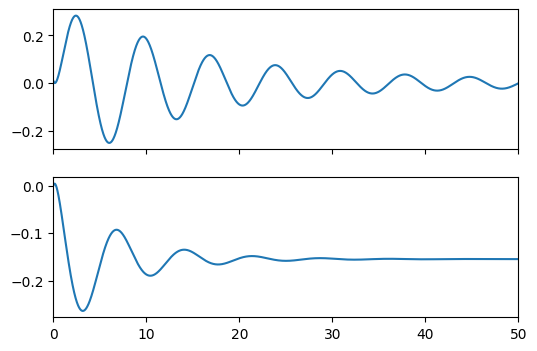

In [106]:
t = np.arange(n_steps) * dt

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(t, CL_ctrl)
ax[1].plot(t, rho)
ax[1].set_xlim([0, 50])
plt.show()


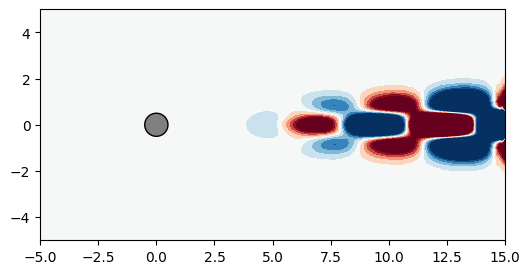

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

### Kalman filter

Still use full-state feedback control (from the previous run), but test KF implementation

In [108]:
# kf_sys = control.ss(A_hat, np.hstack((B_hat, L)), C_hat, np.hstack((D_hat, [0.0])))
# np.hstack((B_hat, L)).shape

# Zero-order hold discretization
A_kf = linalg.expm(A_hat * dt)
B_kf = np.linalg.solve(A_hat, (A_kf - np.eye(r))) @ B_hat
C_kf = C_hat
D_kf = D_hat

In [115]:
# Kalman filter

Qf = np.eye(r)
Rf = 1e-12 * np.eye(p)
L, _, E = control.dlqr(A_kf.T, C_kf.T, Qf, Rf)
L = L.T
print(L[:2])
# print(np.log(E) / dt)

[[122.69351306]
 [-54.53854203]]


In [116]:
y = CL_ctrl

n_steps = len(t)
z = np.zeros((n_steps, r), dtype=complex)  # Kalman filter estimate
y_hat = np.zeros((n_steps, p))  # Kalman filter output

z[0] = x[0]
for i in range(1, n_steps):
    # y_hat[i] = np.real(C_kf @ z[i-1] + D_kf * u[i-1])
    # y_hat[i] = np.real(C_kf @ z[i-1] + D_kf * u[i-1])
    y_hat[i] = np.real(C_kf @ z[i-1])
    z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])

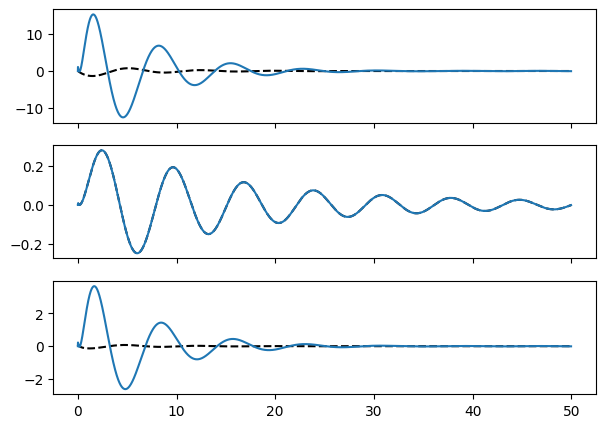

In [117]:

fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, x[:, 0], 'k--')
ax[0].plot(t, z[:, 0])
ax[1].plot(t, y, 'k--')
ax[1].plot(t, y_hat)
ax[2].plot(t, x @ K.T, 'k--')
ax[2].plot(t, z @ K.T)
# ax[2].set_ylim([-5, 5])
plt.show()

# Boundary condition control

In [68]:
 # The full flow field with BCs is q = qH + qC * rho, where qH is the solution
# to the homogeneous problem with forcing.  Since the controller was designed
# based on qH, this is the value we want to use for the feedback: u = K * x, with
# x = T @ z the real-valued reduced state and z = W^T @ qH = W^T @ (q - qC * rho)
# the complex-valued reduced state (in the eigenbasis).  We can pre-compute the term
# T @ (W^T @ qC) and subtract it from the full flow field projection at each step

zC = np.array([flow.inner_product(qC, W[j]) for j in range(r)])
xC = np.real(T_inv @ zC)

# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0)

# tf = 100
# n_steps = int(tf // dt)
CL_bc = np.zeros(n_steps)
CD_bc = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# Integrated control signal (this is the BC value)
rho = np.zeros((n_steps, m))

flow.q.assign(solver.q)
for i in range(n_steps):

    # LQR control
    if i > 0: 
        # Project the flow field onto the reduced basis
        z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

        # Transform to the real-valued reduced state space and offset by
        # the BC value to shift to the corresponding homogeneous solution
        x[i] = np.real(T_inv @ z)

        # LQR control
        if complex_rom:
            u[i] = np.real(K @ (z - zC * rho[i-1]))
        else:
            u[i] = -K @ (x[i] - xC * rho[i-1])

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        # The Dirichlet boundary condition is the integrated negative control signal
        # c(t) = -drho/dt
        if i > 0:
            rho[i] = rho[i-1] - dt * u[i]

        # bc_scale = flow.advance_time(dt, c[i])[0].real
        # rho[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
        # flow.set_control(c[i])
        flow.bcu_actuation[0].set_scale(rho[i])

    q = solver.step()
    flow.q.assign(q)
    CL_bc[i], CD_bc[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_bc[i]:.4f}, CD={CD_bc[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=[0.]
t=0.01, CL=0.0089, CD=0.0000
   u=[-0.06032895], rho=[0.00060329]
t=0.02, CL=0.0082, CD=0.0000
   u=[-0.05513902], rho=[0.00115468]
t=0.03, CL=0.0074, CD=0.0000
   u=[-0.04981728], rho=[0.00165285]
t=0.04, CL=0.0068, CD=-0.0000
   u=[-0.04455211], rho=[0.00209837]
t=0.05, CL=0.0062, CD=-0.0000
   u=[-0.03940319], rho=[0.00249241]
t=0.06, CL=0.0056, CD=-0.0000
   u=[-0.03438744], rho=[0.00283628]
t=0.07, CL=0.0052, CD=-0.0000
   u=[-0.02950766], rho=[0.00313136]
t=0.08, CL=0.0047, CD=-0.0000
   u=[-0.02476203], rho=[0.00337898]
t=0.09, CL=0.0044, CD=-0.0000
   u=[-0.02014728], rho=[0.00358045]
t=0.10, CL=0.0041, CD=-0.0000
   u=[-0.01565977], rho=[0.00373705]
t=0.11, CL=0.0038, CD=-0.0000
   u=[-0.01129579], rho=[0.00385001]
t=0.12, CL=0.0036, CD=-0.0000
   u=[-0.00705169], rho=[0.00392052]
t=0.13, CL=0.0034, CD=-0.0000
   u=[-0.00292393], rho=[0.00394976]
t=0.14, CL=0.0032, CD=-0.0000
   u=[0.00109091], rho=[0.00393885]
t=0.15, CL=0.003

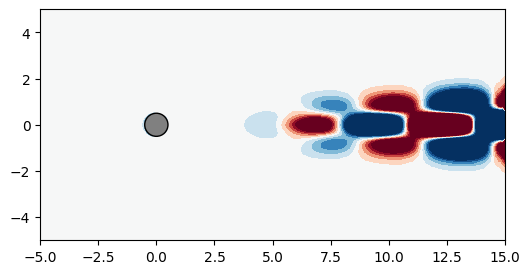

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

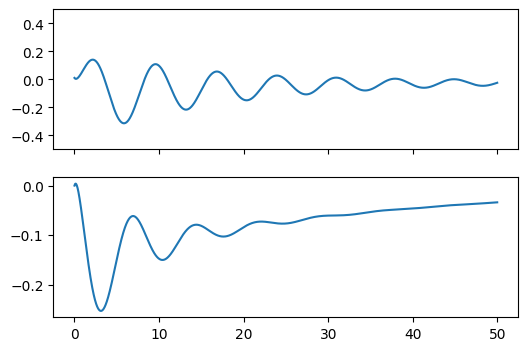

In [70]:
t = np.arange(n_steps) * dt

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(t, CL_bc)
ax[0].set_ylim([-0.5, 0.5])
ax[1].plot(t, rho)

# NEXT STEPS

* Kalman filter: test estimation while keeping full-state feedback
* LQG: combine Kalman filter with LQR
* BPOD: collect snapshots from direct and adjoint simulations
* Balanced model reduction for stable subspace

# Closed-loop simulation (LQG)

In [ ]:
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))
solver.q.assign(q0)

tf = 50
n_steps = int(tf // dt)
m = 1
p = 1

t = dt * np.arange(n_steps)
x = np.zeros((n_steps, r))  # Reduced state
u = np.zeros((n_steps))  # Control signal
y = np.zeros((n_steps))  # Measurement signal

# Integrated control signal (this would be the BC value)
rho = np.zeros(n_steps)

flow.q.assign(solver.q)
for i in range(n_steps):
    CL, CD = map(np.real, flow.get_observations())
    y[i] = CL
    xc = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])
    x[i] = np.real(T_inv @ xc)
    u[i] = -K @ x[i]

    c.assign(u[i])

    if i > 0:
        rho[i] = rho[i-1] - dt * u[i]

    if i % 10 == 0:
        hgym.print(f"t={t[i]:.2f}, y={y[i]:.4f}, u={u[i]:.4f}")

    q = solver.step()
    flow.q.assign(q)

np.savez(f"{output_dir}/sine_actuation_ex.npz", t=t, y=y, u=u, x=x, rho=rho)

